# Dreidel Simulation Data
I generated some driedel data using [this script](https://github.com/zrottman/dreidel-simulator) I built. Now it's time to get to the bottom of how long (i.e., how many spins o' the dreidel) a typical game takes based on two variables: the number of players and each player's starting bankroll amount.

This dataset looks at games involving 2-6 players, and starting bankrolls from 3–10 units. For each player-bankroll combination, I've run 3,000 simulations.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dreidel = pd.read_csv('../data/dreidel_data3.csv')
dreidel.head()

,players,bankroll_start,winner,rounds,spins
0,2,3,player1,4,6
1,2,3,player1,4,6
2,2,3,player2,3,3
3,2,3,player1,5,7
4,2,3,player1,4,6


## Takeaway #1: This Game Takes Way Too Damn Long

First things first. How many spins does a typical game take? Too damn many!

Let's take a look at the distribution of spin counts for a subset of the data--say, games with 3-6 players and 5-unit starting bankrolls.

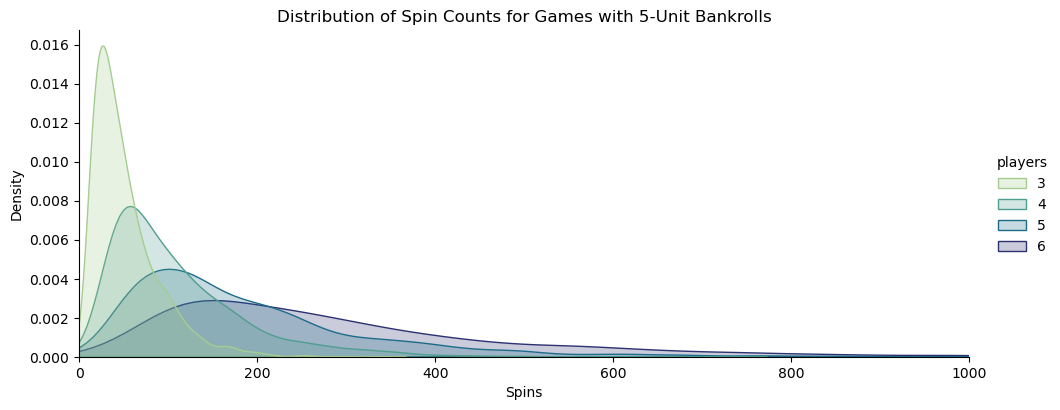

In [146]:
df = dreidel[(dreidel['bankroll_start'] == 5) & (dreidel['players'] > 2)]

sns.displot(
    x='spins',
    hue='players',
    kind='kde',
    height=4,
    aspect=2.5,
    palette='crest',
    common_norm=False,
    fill=True,
    data=df
)
plt.title('Distribution of Spin Counts for Games with 5-Unit Bankrolls')
plt.xlabel('Spins')
plt.xlim(0, 1000);

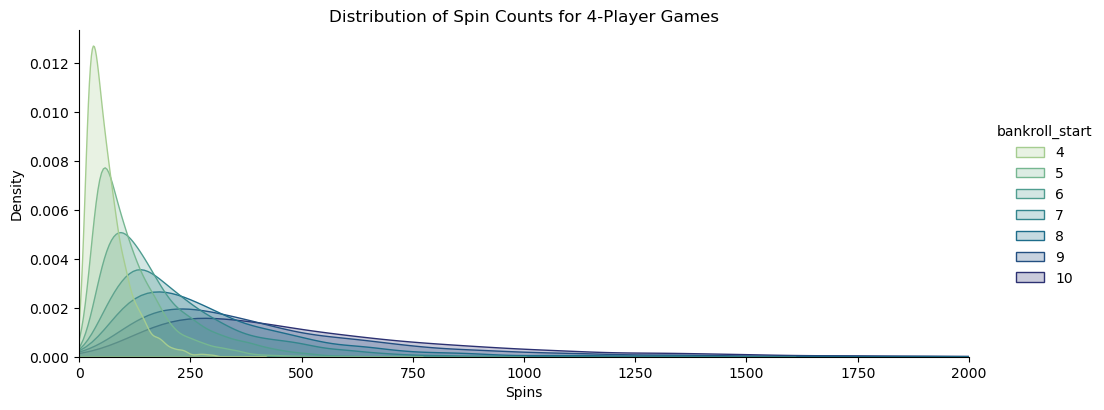

In [145]:
df = dreidel[(dreidel['bankroll_start'] > 3) & (dreidel['players'] == 4)]

sns.displot(
    x='spins',
    hue='bankroll_start',
    kind='kde',
    height=4,
    aspect=2.5,
    palette='crest',
    common_norm=False,
    fill=True,
    data=df
)
plt.title('Distribution of Spin Counts for 4-Player Games')
plt.xlabel('Spins')
plt.xlim(0, 2000);

We can immediately see that these distributions are positively skewed, meaning that there are games with very high spin counts that are going to bias the mean in that direction. Because of that, I'll rely on the median and interquartile range as better indicators of central tendency and variance, respectively.

Let's take a closer look at the median spin count per game based on the number of players and starting bankroll amounts:

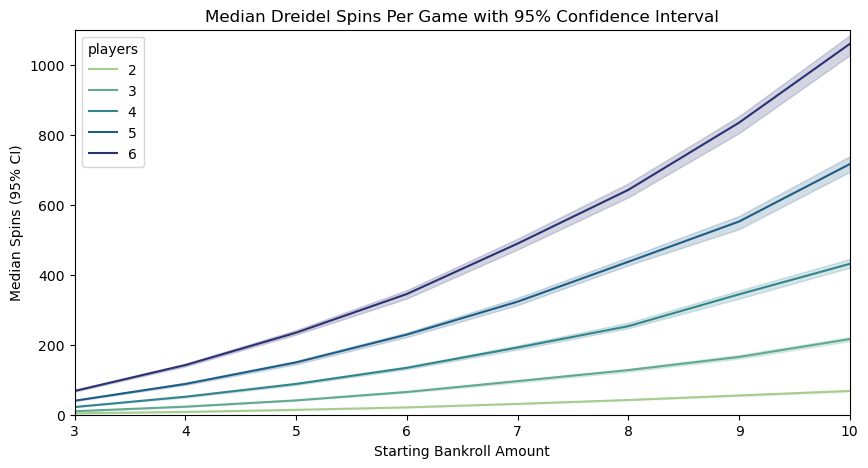

In [143]:
plt.subplots(figsize=(10, 5))
sns.lineplot(
    data=dreidel, 
    x='bankroll_start', 
    y='spins', 
    hue='players', 
    ci=95, 
    estimator=np.median, 
    palette='crest'
)

plt.title('Median Dreidel Spins Per Game with 95% Confidence Interval')
plt.xlabel('Starting Bankroll Amount')
plt.ylabel('Median Spins (95% CI)')
plt.xlim(3, 10)
plt.ylim(0, 1100)
plt.xticks(range(3, 11));

That right there is a lot of spins. More players = more spins, more bankroll = more spins.

Let's look at a few more examples just to drive the point home. Let's say it's Channukah and you and three pals are lookin' for some action. But not too much action. How many pieces of gilt do you each start with?

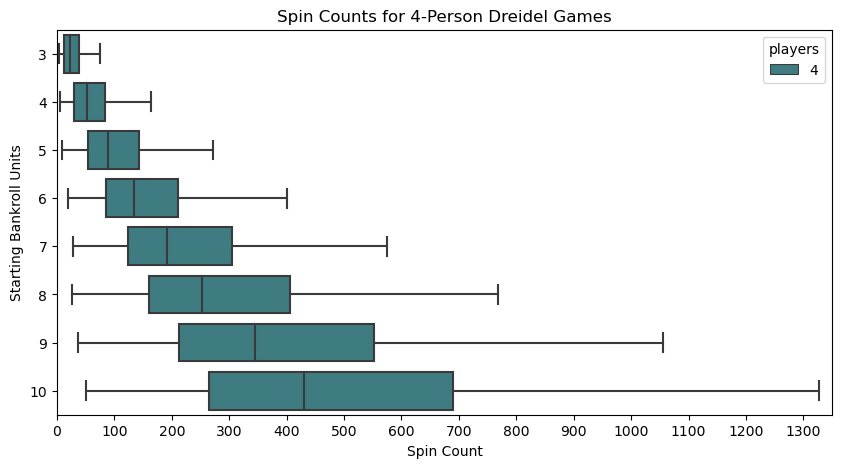

In [51]:
df = dreidel[(dreidel['players'] == 4) & (dreidel['bankroll_start'] < 11)]

plt.subplots(figsize=(10,5))
sns.boxplot(
    data=df,
    x='spins',
    y='bankroll_start',
    hue='players',
    showfliers=False, 
    palette='crest',
    orient='h',
)

plt.title('Spin Counts for 4-Person Dreidel Games')
plt.xlabel('Spin Count')
plt.ylabel('Starting Bankroll Units')
plt.xlim(0, 1350)
plt.xticks(range(0, 1350, 100));

In [52]:
df.groupby(by='bankroll_start')['spins'].describe()

,count,mean,std,min,25%,50%,75%,max
bankroll_start,,,,,,,,
3,3000.0,29.195667,23.115251,4.0,13.0,22.0,38.00,208.0
4,3000.0,64.406000,47.311971,6.0,30.0,51.5,83.25,392.0
5,3000.0,110.155333,80.445939,8.0,54.0,88.0,142.00,724.0
6,3000.0,164.743000,114.746587,19.0,85.0,134.0,211.25,936.0
7,3000.0,238.506333,167.970233,27.0,123.0,192.0,304.25,1509.0
8,3000.0,313.987667,224.596416,26.0,161.0,253.0,406.00,2510.0
9,3000.0,425.398000,300.519545,36.0,213.0,344.0,552.00,2274.0
10,3000.0,530.523000,367.140817,50.0,265.0,431.0,690.25,3566.0


In [66]:
# Compute minutes per quantile at 6 spins/minute
df[df['bankroll_start'] == 10]['spins'].quantile([.05, .25, .5, .75, .95]) / 6

0.05     22.825000
0.25     44.166667
0.50     71.833333
0.75    115.041667
0.95    212.683333
Name: spins, dtype: float64

Think 10 pieces of gilt each is reasonable? Think again, chump. If the gang is feeling frenzied and manages to crank that dreidel once every 10 seconds on average, you're still looking at a median game length of 72 minutes to get through all 431 spins. Sure, maybe you guys get lucky and finish in 20 minutes or less—congratulations, you're in the top 5% when it comes to quickest games! But more likely you'll land in the middle 50% of games, which require anywhere from 265 to 690 spins. With your commitment to supersonic dreidling, you'll finish in 45 minutes to 2 hours.

Let's say we're willing to dreidel for a half hour and that we're committing to 6 spins a minute. So, games requiring less than 180 spins. Let's look for a more realistic starting bankroll amount.

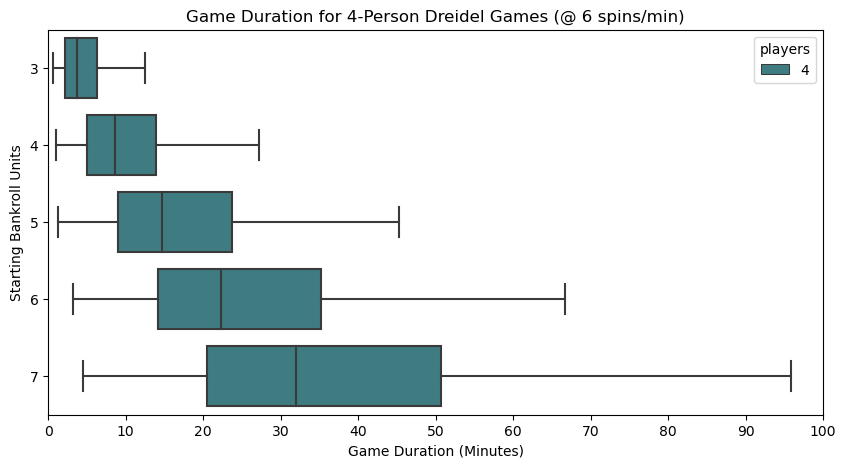

In [100]:
df = dreidel[(dreidel['players'] == 4) & (dreidel['bankroll_start'] < 8)].copy()
df['minutes'] = df['spins'] / 6

plt.subplots(figsize=(10,5))
sns.boxplot(
    data=df,
    x='minutes',
    y='bankroll_start',
    hue='players',
    showfliers=False, 
    palette='crest',
    orient='h',
)

plt.title('Game Duration for 4-Person Dreidel Games (@ 6 spins/min)')
plt.xlabel('Game Duration (Minutes)')
plt.ylabel('Starting Bankroll Units')
plt.xlim(0, 70)
plt.xticks(range(0, 110, 10));

As long as the gang can keep twisting 6 times a minute, you should have things wrapped up in a half hour as long as you start with 5 units or less. You're pushing in with 6, though.

So far we've been considering a gang of four. More people = longer games. Let's have a look at the full dataset in another way to see how the two variables--number of players and starting bankrolls--affect median spins per game.

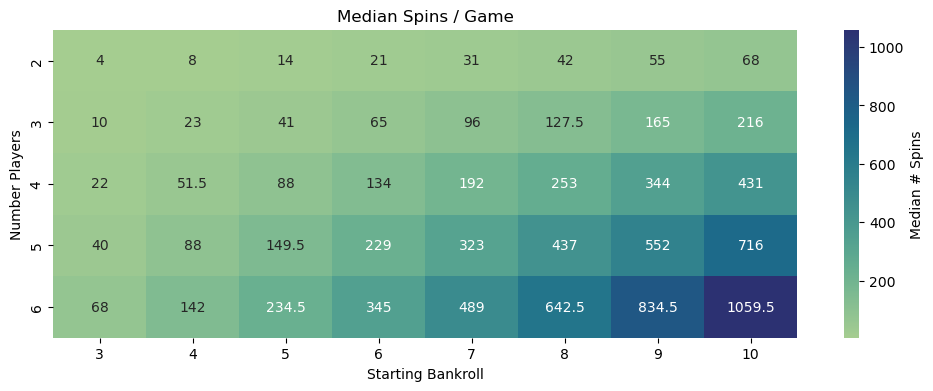

In [99]:
df = dreidel.pivot_table(values='spins', index='players', columns='bankroll_start', aggfunc=np.median)

plt.subplots(figsize=(12, 4))
sns.heatmap(
    data=df,
    cmap='crest',
    annot=True,
    fmt='g',
    cbar_kws={'label':'Median # Spins'}
)
plt.title('Median Spins / Game')
plt.xlabel('Starting Bankroll')
plt.ylabel('Number Players');

## Takeaway #2: This Game Ain't Fair

Turns out, you spin first, you got the edge. In fact, the earlier you are in the spin order, the better the chance you have at winning it all. Have a look:

In [124]:
# Compute proportion of winners grouped by number of players
df = dreidel.groupby(by=['players'])[['winner']].value_counts(normalize=True).unstack()
df

winner,player1,player2,player3,player4,player5,player6
players,,,,,,
2,0.508000,0.492000,NaN,NaN,NaN,NaN
3,0.374417,0.321833,0.303750,NaN,NaN,NaN
4,0.298208,0.250167,0.229542,0.222083,NaN,NaN
5,0.256000,0.207625,0.191083,0.175917,0.169375,NaN
6,0.229292,0.182375,0.167625,0.149250,0.138583,0.132875


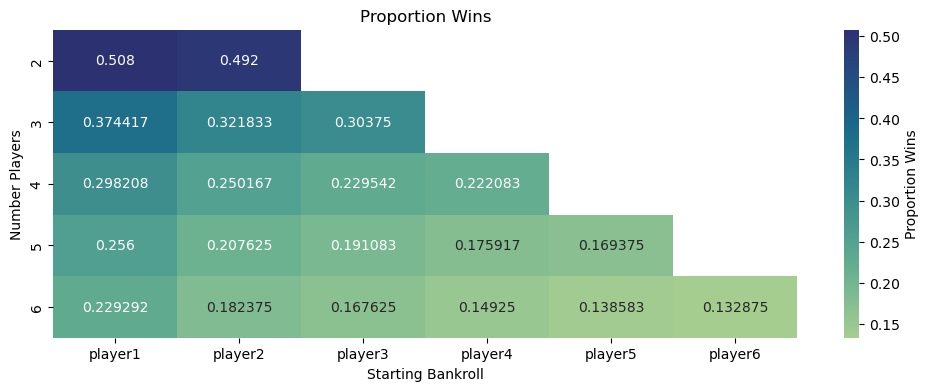

In [126]:
plt.subplots(figsize=(12, 4))
sns.heatmap(
    data=df,
    cmap='crest',
    annot=True,
    fmt='g',
    cbar_kws={'label':'Proportion Wins'}
)
plt.title('Proportion Wins')
plt.xlabel('Starting Bankroll')
plt.ylabel('Number Players');

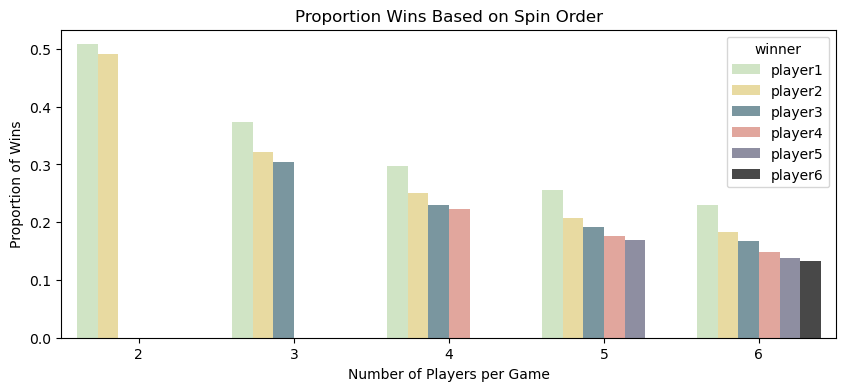

In [144]:
df = dreidel.groupby(by=['players'], as_index=False)[['winner']].value_counts(normalize=True)
sns.set_palette(['#CAE7B9', '#F3DE8A', '#658E9C', '#EB9486', '#7E7F9A', '#343434'])
plt.subplots(figsize=(10, 4))
sns.barplot(x='players', y='proportion', hue='winner', data=df, alpha=.9)
plt.title('Proportion Wins Based on Spin Order')
plt.xlabel('Number of Players per Game')
plt.ylabel('Proportion of Wins');